In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d charunisa/chatgpt-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/charunisa/chatgpt-sentiment-analysis
License(s): CC0-1.0
  0% 0.00/13.7M [00:00<?, ?B/s]
100% 13.7M/13.7M [00:00<00:00, 1.14GB/s]


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile('/content/chatgpt-sentiment-analysis.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import pandas as pd
data=pd.read_csv('/content/file.csv')

In [ ]:
data.head()

,Unnamed: 0,tweets,labels
0,0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,1,"Try talking with ChatGPT, our new AI system wh...",good
2,2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,3,"THRILLED to share that ChatGPT, our new model ...",good
4,4,"As of 2 minutes ago, @OpenAI released their ne...",bad


In [ ]:
data = data.drop(columns=["Unnamed: 0"])

In [ ]:
data.head()

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad


<Axes: xlabel='labels'>

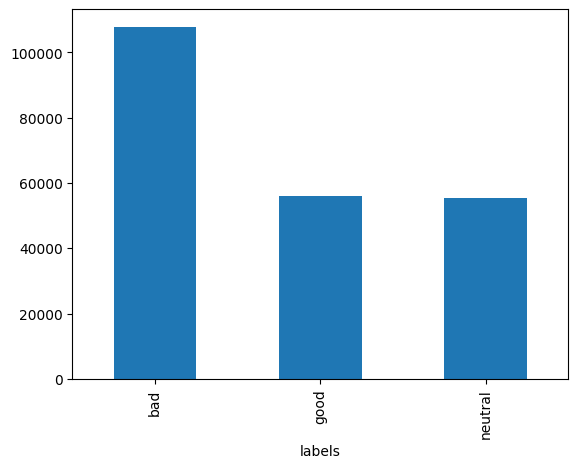

In [ ]:
data['labels'].value_counts().plot(kind='bar')

In [ ]:
label_map = {"good": 0, "bad": 1, "neutral": 2}
data["label_encoded"] = data["labels"].map(label_map)


In [ ]:
data.head()

,tweets,labels,label_encoded
0,ChatGPT: Optimizing Language Models for Dialog...,neutral,2
1,"Try talking with ChatGPT, our new AI system wh...",good,0
2,ChatGPT: Optimizing Language Models for Dialog...,neutral,2
3,"THRILLED to share that ChatGPT, our new model ...",good,0
4,"As of 2 minutes ago, @OpenAI released their ne...",bad,1


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Embedding # Import Embedding layer
from transformers import AutoTokenizer, TFAutoModel


In [ ]:
X = data["tweets"].tolist()
y = data["label_encoded"].values


In [ ]:
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# ✅ 5. Tokenize and Encode Inputs
train_encodings = tokenizer(X_train_texts, padding='max_length', truncation=True, max_length=128)
test_encodings = tokenizer(X_test_texts, padding='max_length', truncation=True, max_length=128)

train_input_ids = np.array(train_encodings['input_ids'])
test_input_ids = np.array(test_encodings['input_ids'])

# ✅ 6. Compute Class Weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def build_model(vocab_size, embed_dim=128):
    input_ids = Input(shape=(128,), dtype=tf.int32)
    x = Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=128)(input_ids)
    x = LSTM(128, return_sequences=False)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=input_ids, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

vocab_size = tokenizer.vocab_size
model = build_model(vocab_size)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 128, 128)       │     3,906,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,039,299 (15.41 MB)

 Trainable params: 4,039,043 (15.41 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
model.fit(train_input_ids, y_train,
          validation_data=(test_input_ids, y_test),
          epochs=5,
          class_weight=class_weight_dict,
          batch_size=32)

# ✅ 8. Evaluate on Test Set
y_pred_probs = model.predict(test_input_ids)
y_pred = np.argmax(y_pred_probs, axis=1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=["good", "bad", "neutral"]))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))


Epoch 1/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 286s 49ms/step - accuracy: 0.3421 - loss: 1.0990 - val_accuracy: 0.2556 - val_loss: 1.1492
Epoch 2/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 299s 46ms/step - accuracy: 0.5660 - loss: 0.8100 - val_accuracy: 0.8822 - val_loss: 0.3737
Epoch 3/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 262s 46ms/step - accuracy: 0.9207 - loss: 0.2438 - val_accuracy: 0.9229 - val_loss: 0.2262
Epoch 4/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 271s 47ms/step - accuracy: 0.9423 - loss: 0.1810 - val_accuracy: 0.9307 - val_loss: 0.2003
Epoch 5/5
5483/5483 ━━━━━━━━━━━━━━━━━━━━ 272s 49ms/step - accuracy: 0.9550 - loss: 0.1446 - val_accuracy: 0.9331 - val_loss: 0.1985
1371/1371 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step

Classification Report:
              precision    recall  f1-score   support

        good       0.93      0.93      0.93     11202
         bad       0.98      0.95      0.96     21559
     neutral       0.85      0.90      0.88     11098

    accuracy                           0.93     43859

In [ ]:
# ✅ 9. Save the model
model.save("sentiment_lstm_model.keras")

In [ ]:
 from google.colab import files
 files.download("sentiment_lstm_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

ValueError: Exception encountered when calling layer 'tf_bert_model_2' (type TFBertModel).

Data of type <class 'keras.src.backend.common.keras_tensor.KerasTensor'> is not allowed only (<class 'tensorflow.python.framework.tensor.Tensor'>, <class 'bool'>, <class 'int'>, <class 'transformers.utils.generic.ModelOutput'>, <class 'tuple'>, <class 'list'>, <class 'dict'>, <class 'numpy.ndarray'>) is accepted for input_ids.

Call arguments received by layer 'tf_bert_model_2' (type TFBertModel):
  • input_ids=['<KerasTensor shape=(None, None), dtype=int32, sparse=False, name=input_ids>', '<KerasTensor shape=(None, None), dtype=int32, sparse=False, name=attention_mask>']
  • attention_mask=None
  • token_type_ids=None
  • position_ids=None
  • head_mask=None
  • inputs_embeds=None
  • encoder_hidden_states=None
  • encoder_attention_mask=None
  • past_key_values=None
  • use_cache=None
  • output_attentions=None
  • output_hidden_states=None
  • return_dict=None
  • training=False